In [ ]:
pip install gensim matplotlib wordcloud

In [3]:
%matplotlib inline

import pprint
import os


In [4]:
def remove_extra(doctext):
    """
    Remove extra characters that are not to be used in the analysis
    """
    
    doc = doctext.replace('# Reusable Component Library System Security Plan', "").replace('```text', "").replace('```', '').replace("'", "").replace('*', "")
    return doc

In [5]:
def read_markdown(filename):
    """
    Read in a file as a string
    """
    
    file_string = """{}""".format(open(f'{root}/{filename}.md', encoding="utf8").read())
    return file_string


In [7]:
# Folder with controls
root = f"{os.getcwd()}/docs/controls"

# Control Markdown files sourced from SSP toolkit
AC_doc = read_markdown("AC")
AP_doc = read_markdown("AP")
AR_doc = read_markdown("AR")

# Cleaning controls
AC_doc = remove_extra(AC_doc)
AP_doc = remove_extra(AP_doc)
AR_doc = remove_extra(AR_doc)

# clean up
print(AC_doc)



# NIST SP 800-53 Revision 4

## AC: Access Control

### AC-1: Access Control Policy And Procedures


The organization:
  a.  Develops, documents, and disseminates to [Assignment: organization-defined
personnel or roles]:
    1.  An access control policy that addresses purpose, scope, roles, responsibilities,
management commitment, coordination among organizational entities, and compliance; and
    2.  Procedures to facilitate the implementation of the access control policy
and associated access controls; and
  b.  Reviews and updates the current:
    1.  Access control policy [Assignment: organization-defined frequency]; and
    2.  Access control procedures [Assignment: organization-defined frequency].


Status: Complete

##### CivicActions

CivicActions has developed, documented and disseminated to personnel an access control policy that addresses purpose, scope, roles, responsibilities, management commitment, coordination among organizational entities, and compliance; and procedur

In [7]:
# control corpus

text_corpus = [
    AC_doc,
    AP_doc,
    AR_doc
]

In [8]:
# Create a set of frequent words
stoplist = set("for a of the and to in as are or and/or * # ## ### #### ##### – - 1. 2. 3. 4. 1 2 3 4 a. b. c. d. a b c d".split(' '))

# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
#pprint.pprint(processed_corpus)

In [9]:
from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
pprint.pprint(dictionary.token2id)

Dictionary(449 unique tokens: ['(ac)', '(e.g.', '(iam)', '800-53', '[assignment:']...)
{'"the': 409,
 '(ac)': 0,
 '(e.g.': 1,
 '(iam)': 2,
 '(pii)': 410,
 '800-53': 3,
 '[assignment:': 4,
 'access': 5,
 'access.': 6,
 'access;': 7,
 'accessible': 8,
 'accessing': 9,
 'accordance': 10,
 'according': 11,
 'account': 12,
 'account/node': 13,
 'accounting': 423,
 'accounts': 14,
 'accounts.': 15,
 'accounts;': 16,
 'action': 17,
 'actions': 18,
 'activities': 19,
 'additional': 20,
 'address': 411,
 'addresses': 21,
 'admin': 22,
 'administration,': 23,
 'administrative': 24,
 'administrator': 25,
 'administrator,': 26,
 'administrators': 27,
 'after': 28,
 'agency': 29,
 'align': 30,
 'all': 31,
 'allow': 32,
 'allowing': 33,
 'allows.': 34,
 'amazon': 35,
 'among': 36,
 'an': 37,
 'anonymous': 38,
 'any': 39,
 'api': 40,
 'applicable': 41,
 'applicable.': 42,
 'application': 43,
 'appropriate': 44,
 'approvals': 45,
 'approved': 46,
 'architecture,': 47,
 'assigned': 48,
 'assigns': 49,


In [10]:
new_doc = "Access Documents"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)

[(5, 1), (129, 1)]


In [11]:
# convert our entire original corpus to a list of vectors:

In [12]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
pprint.pprint(bow_corpus)

[[(0, 2),
  (1, 2),
  (2, 3),
  (3, 1),
  (4, 15),
  (5, 87),
  (6, 2),
  (7, 2),
  (8, 12),
  (9, 2),
  (10, 7),
  (11, 4),
  (12, 36),
  (13, 2),
  (14, 35),
  (15, 6),
  (16, 3),
  (17, 2),
  (18, 5),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 2),
  (23, 2),
  (24, 2),
  (25, 11),
  (26, 2),
  (27, 4),
  (28, 3),
  (29, 2),
  (30, 2),
  (31, 21),
  (32, 4),
  (33, 4),
  (34, 2),
  (35, 9),
  (36, 2),
  (37, 23),
  (38, 12),
  (39, 9),
  (40, 2),
  (41, 2),
  (42, 3),
  (43, 3),
  (44, 4),
  (45, 2),
  (46, 2),
  (47, 3),
  (48, 5),
  (49, 3),
  (50, 5),
  (51, 4),
  (52, 9),
  (53, 4),
  (54, 2),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 7),
  (59, 2),
  (60, 3),
  (61, 4),
  (62, 17),
  (63, 4),
  (64, 3),
  (65, 12),
  (66, 4),
  (67, 3),
  (68, 2),
  (69, 13),
  (70, 2),
  (71, 8),
  (72, 5),
  (73, 2),
  (74, 2),
  (75, 2),
  (76, 1),
  (77, 27),
  (78, 11),
  (79, 2),
  (80, 2),
  (81, 2),
  (82, 31),
  (83, 2),
  (84, 3),
  (85, 2),
  (86, 2),
  (87, 2),
  (88, 3),
  (89, 11),
  (9

In [13]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "access security".lower().split()
print(tfidf[dictionary.doc2bow(words)])

[(336, 1.0)]


In [14]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id)) # len(dictionary.token2id) is the number of features

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [15]:
#query_document = 'access security'.split()
query_document = texts[0]# AC.md after all pre-processing
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]
print(list(enumerate(sims)))

[(0, 0.99999964), (1, 0.06376363), (2, 0.06568639)]


How to read this output?
Document 1 has a similarity score of 0.99999994=99%, document 2 has a similarity score of 6% etc.
We can make this slightly more readable by sorting:



In [16]:
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(document_number, score)

0 0.99999964
2 0.06568639
1 0.06376363


# Word clouds

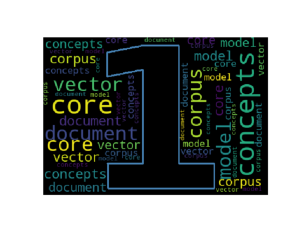

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('img/run_core_concepts.png')
imgplot = plt.imshow(img)
_ = plt.axis('off')

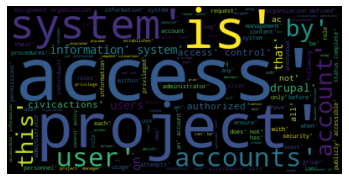

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Start with one document:
text = str(texts[0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("img/AC_wordcloud_example.png")


# Latent Semantic Indexing:

In [48]:
from gensim import models
lsi = models.LsiModel(bow_corpus, id2word=dictionary, num_topics=2)

In [49]:
doc = AC_doc
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
print(vec_lsi)

[(0, 203.90497582391419), (1, -5.976558668608939)]


In [50]:
from gensim import similarities
index = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it

# Similiarity Query

In [51]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 1.0), (1, 0.74575377), (2, 0.26252878)]


# sort

In [53]:
sims = sorted(enumerate(sims), key=lambda item: item[-1])
for doc_position, doc_score in sims:
    print(doc_score, texts[doc_position][0])# just printing the first word in a document

(0, 1.0) nist
(1, 0.74575377) nist
(2, 0.26252878) nist


# Many to many

For a many to many running of the above just create a model and use a list of like-documents(SSPs or control text model) in a list and chugging through doing similarity queries, etc. Again the model is an algorithm for the give type of documents so if the documents are SSPs then the model should be used to make NLP predictions for whole SSPs. Likewise, for a model built from controls only predicts controls.  
